# Análisis de clustering del Registro Federal de Cultura

### Seteo parámetros

In [1]:
# Importamos las librerías.
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path
import matplotlib as mpl


# Importamos las librerías para utilizar el método de clustering.
from kmodes.kmodes import KModes
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

In [2]:
import os
path = os.path.join(os.path.expanduser('~'), 'Documents/Proyectos/herramientas/')
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
font_dir = [path + 'Archivo/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
rcParams['font.family'] = 'Archivo'
font_manager.fontManager

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
fundar_colores_primarios = ['#7BB5C4', '#9FC1AD', '#D3D3E0',  '#8d9bff', '#FF9750', '#FFD900',]
fundar_colores_secundarios = ['#B5E0EA', '#B3B3B3', '#848279', '#AFA36E', '#5D896F', '#9C9CBC', '#E27124']

In [4]:
# Dado que todos los algoritmos tienen una inicialización aleatoria, seteamos una seed para que nuestros resultados no cambien
random.seed(10)

### Importamos y trabajamos con la base

In [5]:
# Cargamos el csv del Registro
df = pd.read_csv('data/RFC_limpio.csv')

C:\Users\Pluvini\AppData\Local\Temp\ipykernel_20068\828824459.py:2: DtypeWarning: Columns (53,75,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
print('Tenemos: {} líneas y {} columnas'.format(df.shape[0], df.shape[1]))

Tenemos: 112055 líneas y 83 columnas


In [7]:
# Nos interesa incluir como variable si se está inscripto a un registro o no, por lo que creamos esta variable donde 
#'Si' implica si está inscripto a uno o más registros y 'No' a ninguno
conditions = [(df['Inscripto.a.registros']=='No'), (df['Inscripto.a.registros']!='No')]
df['Inscripto_registros_RECAT'] = np.select(conditions, ['no','si'])

In [8]:
# Acá selecciono qué variables quiero incluir para hacer el clustering. Estas pueden cambiar y eso va a depender del objeto del análisis
columns = ['Provincia.de.residencia', 'Identidad.de.género.autopercibida_RECAT','Porcentaje.de.ingresos.provenientes.de.la.actividad.cultural.',
             'Área.principal','Situación.ocupacional.en.la.actividad.cultural.principal','Inscripto_registros_RECAT']

In [9]:
catColumnsPos = [df.columns.get_loc(col) for col in list(columns)]
print('Categorical columns           : {}'.format(list(columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Provincia.de.residencia', 'Identidad.de.género.autopercibida_RECAT', 'Porcentaje.de.ingresos.provenientes.de.la.actividad.cultural.', 'Área.principal', 'Situación.ocupacional.en.la.actividad.cultural.principal', 'Inscripto_registros_RECAT']
Categorical columns position  : [4, 52, 43, 16, 41, 83]


In [10]:
# Para hacer la matriz que voy a usar como input en los clusters no puedo tener valores nulos. Reviso cuáles columnas tienen Nan
df_clusters = df[columns]
df_clusters.isna().sum()

Provincia.de.residencia                                           0
Identidad.de.género.autopercibida_RECAT                           0
Porcentaje.de.ingresos.provenientes.de.la.actividad.cultural.    12
Área.principal                                                    0
Situación.ocupacional.en.la.actividad.cultural.principal          6
Inscripto_registros_RECAT                                         0
dtype: int64

In [11]:
# Quito los nulos de las columnas identificadas porque sino no funciona el clustering.

df_clusters = df_clusters[(df_clusters['Porcentaje.de.ingresos.provenientes.de.la.actividad.cultural.'].notna())&
            (df_clusters['Situación.ocupacional.en.la.actividad.cultural.principal'].notna())]

df = df[(df['Porcentaje.de.ingresos.provenientes.de.la.actividad.cultural.'].notna())&
            (df['Situación.ocupacional.en.la.actividad.cultural.principal'].notna())]


In [12]:
# Conviero el dataframe a una matriz
dfMatrix = df_clusters[columns].to_numpy()
dfMatrix

array([['Capital Federal (C.A.B.A.)', 'Varón', 'No corresponde',
        'Música', 'Desocupado', 'no'],
       ['Capital Federal (C.A.B.A.)', 'Mujer', '26 a 50%',
        'Gestión Cultural', 'Dependencia', 'no'],
       ['BUENOS AIRES', 'Mujer', '0 a 25 %', 'Escénicas', 'Becario',
        'no'],
       ...,
       ['BUENOS AIRES', 'otra_abierta', '26 a 50%', 'Escénicas',
        'Desocupado', 'si'],
       ['BUENOS AIRES', 'otra_abierta', '26 a 50%', 'Escénicas',
        'Desocupado', 'si'],
       ['BUENOS AIRES', 'Mujer', '0 a 25 %', 'Gestión Cultural',
        'Monotributista', 'si']], dtype=object)

In [13]:
# Reviso la cantidad de rows en ambos objetos
print(df_clusters.shape)
print(dfMatrix.shape)

(112037, 6)
(112037, 6)


### Método del codo

In [14]:
# Utilizo el método del elbow o del codo para seleccionar la cantidad óptima de clusters.
cost = []
for cluster in range(1, 10):
    try:
        print('cluster:',cluster)
        kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0, n_init = 1)
        kmodes.fit_predict(dfMatrix)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

cluster: 1
Cluster initiation: 1
cluster: 2
Cluster initiation: 2
cluster: 3
Cluster initiation: 3
cluster: 4
Cluster initiation: 4
cluster: 5
Cluster initiation: 5
cluster: 6
Cluster initiation: 6
cluster: 7
Cluster initiation: 7
cluster: 8
Cluster initiation: 8
cluster: 9
Cluster initiation: 9


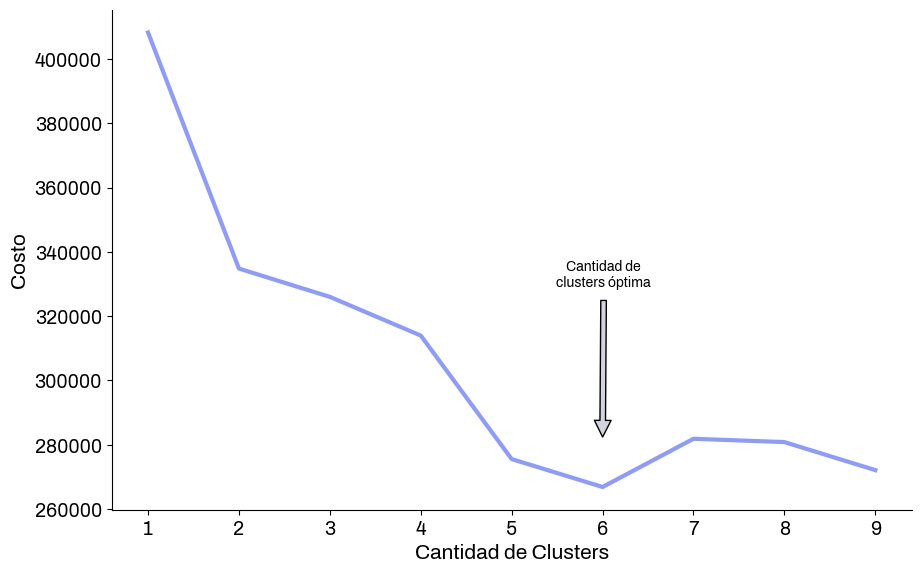

In [15]:
# Grafico los resultados del elbow
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})

fig = plt.figure(figsize=(8,5))
ax = plt.axes([0.1, 0.05, 1, 1])
sns.lineplot(x = df_cost.Cluster, y = df_cost.Cost,color = fundar_colores_primarios[3],linewidth=3)
ax.tick_params(labelsize=15)
ax.set_ylabel('Costo', fontsize=15)
ax.set_xlabel('Cantidad de Clusters', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.annotate('Cantidad de\nclusters óptima',
            xy=(6, 280000),
            xycoords='data',
            xytext=(0.615, 0.5), 
            textcoords='axes fraction',
            arrowprops=dict(facecolor=fundar_colores_primarios[2], shrink=0.05),
            horizontalalignment='center',
            verticalalignment='top')
plt.savefig(f'elbow_method.png'.format(),dpi=200, bbox_inches='tight')
plt.show()

### Clusterizamos con el N seleccionado

In [16]:
# Una vez que seleccioné la cantidad de clusters a encontrar, llevo a cabo la tarea
kmodes = KModes(n_jobs = -1, n_clusters = 6, init = 'Huang', random_state = 0, n_init = 1)
kmodes.fit_predict(dfMatrix)

array([0, 1, 3, ..., 0, 0, 3], dtype=uint16)

In [17]:
# Add the cluster to the dataframe
df_clusters['Cluster Labels'] = kmodes.labels_
df_clusters['Cluster'] = df_clusters['Cluster Labels'].map({0:'Primero', 1:'Segundo', 2:'Tercero',3:'Cuarto',4:'Quinto',5:'Sexto'})#, 6:'Seventh',
df['Cluster Labels'] = kmodes.labels_
df['Cluster'] = df['Cluster Labels'].map({0:'Primero', 1:'Segundo', 2:'Tercero',3:'Cuarto',4:'Quinto',5:'Sexto'})#, 6:'Seventh',


# Order the cluster
df_clusters['Cluster'] = df_clusters['Cluster'].astype('category')
df_clusters['Cluster'] = df_clusters['Cluster'].cat.reorder_categories(['Primero', 'Segundo', 'Tercero', 'Cuarto', 'Quinto','Sexto'])
# Columns for centroids
list_col = ['Cluster Labels', 'Cluster']
cols = [col for col in df_clusters if col not in list_col]
# Create an index for cluster interpretation
index = ['Primero Cluster', 'Segundo Cluster', 'Tercero Cluster', 'Cuarto Cluster', 'Quinto Cluster', 'Sexto Cluster']
# Create the data frame
pd.DataFrame(kmodes.cluster_centroids_, columns = cols, index = index)

,Provincia.de.residencia,Identidad.de.género.autopercibida_RECAT,Porcentaje.de.ingresos.provenientes.de.la.actividad.cultural.,Área.principal,Situación.ocupacional.en.la.actividad.cultural.principal,Inscripto_registros_RECAT
Primero Cluster,BUENOS AIRES,Varón,No corresponde,Música,Desocupado,no
Segundo Cluster,Capital Federal (C.A.B.A.),Mujer,Más del 70%,Escénicas,Trabajador/a informal,si
Tercero Cluster,BUENOS AIRES,Varón,Más del 70%,Música,Trabajador/a informal,si
Cuarto Cluster,BUENOS AIRES,Mujer,0 a 25 %,Escénicas,Trabajador/a informal,no
Quinto Cluster,Capital Federal (C.A.B.A.),Varón,Más del 70%,Escénicas,Monotributista,si
Sexto Cluster,CORDOBA,Mujer,0 a 25 %,Artesanías,Trabajador/a informal,no


In [18]:
# Tamaño de los clusters
(df_clusters.groupby(['Cluster']).size())

Cluster
Primero    32516
Segundo    20233
Tercero    17907
Cuarto     20593
Quinto      7440
Sexto      13348
dtype: int64

In [19]:
# Porcentaje de los cluster sobre observaciones totales
(df_clusters.groupby(['Cluster']).size()/df_clusters.shape[0])

Cluster
Primero    0.290226
Segundo    0.180592
Tercero    0.159831
Cuarto     0.183805
Quinto     0.066407
Sexto      0.119139
dtype: float64

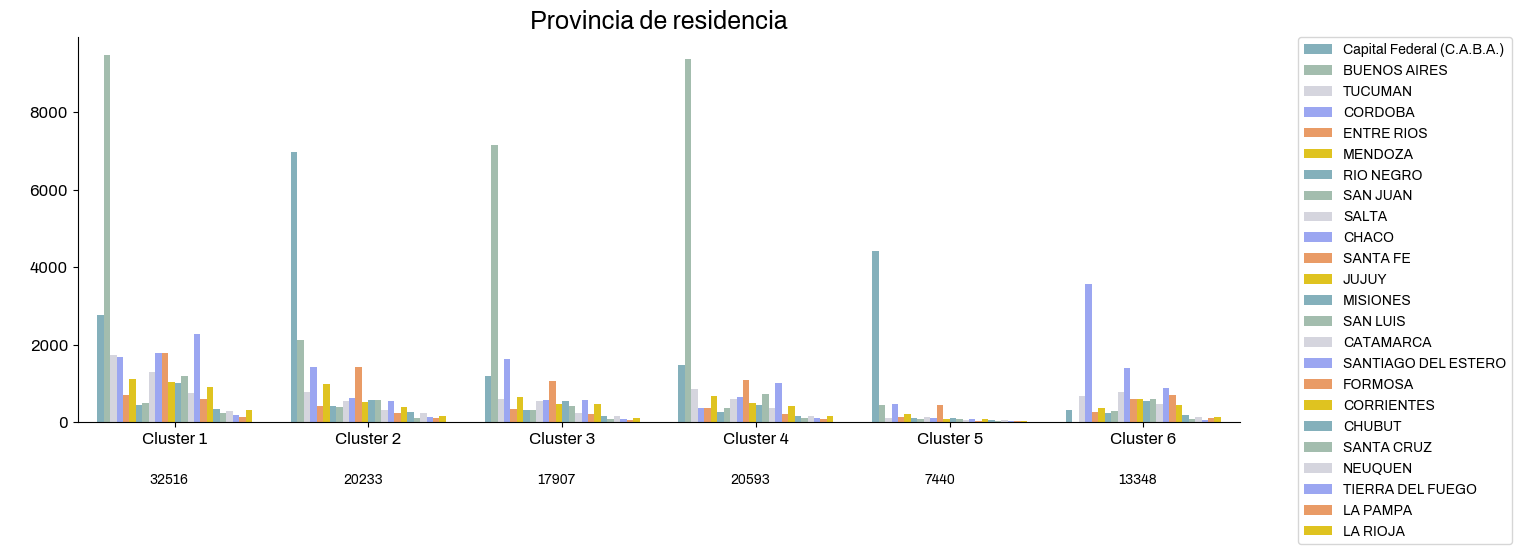

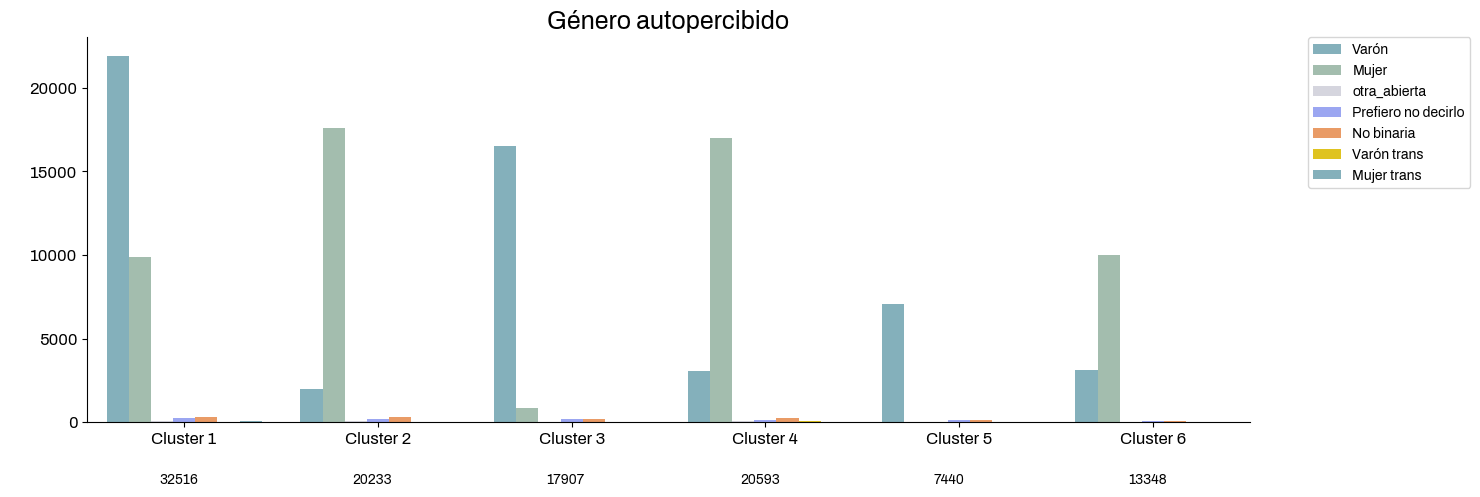

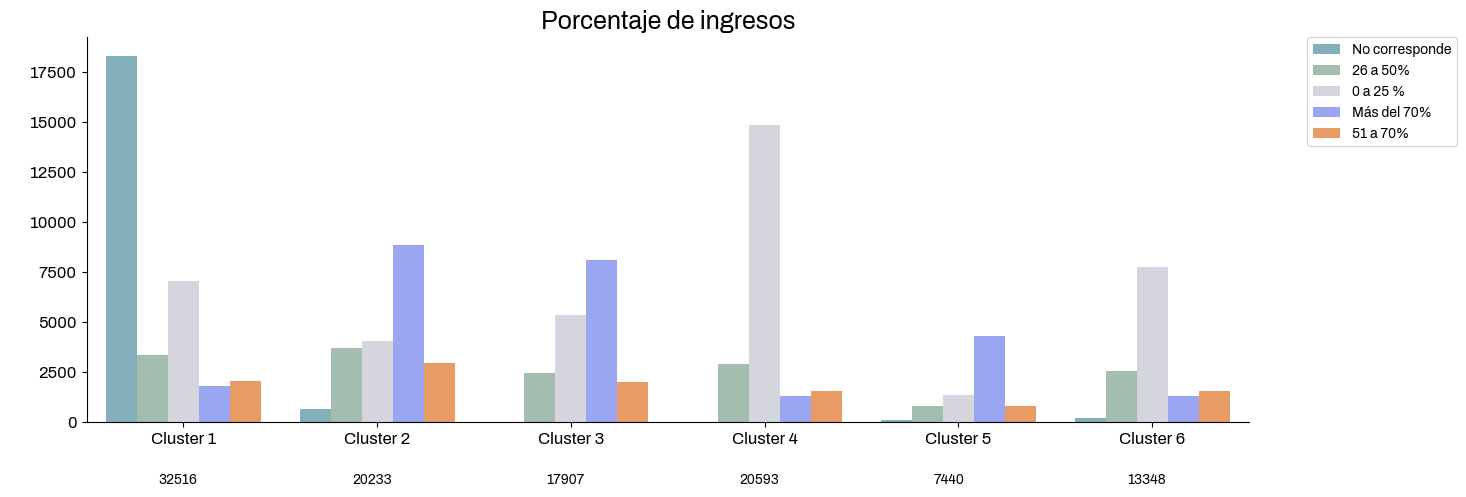

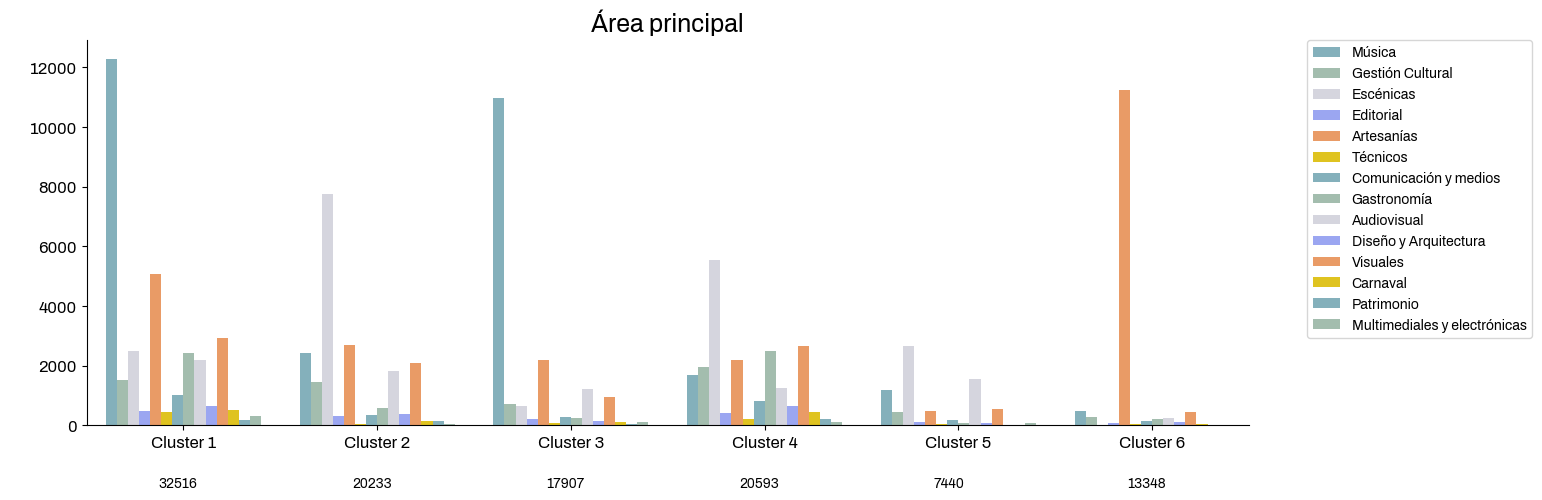

In [20]:
# Grafico la distribución de cada variable dentro de cada cluster

titles = ['Provincia de residencia', 'Género autopercibido','Porcentaje de ingresos','Área principal']
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']
t=0
for column in columns[0:4]:
    plt.subplots(figsize = (15,5))
    ax = sns.countplot(x=df_clusters['Cluster'],hue=df_clusters[column], palette= fundar_colores_primarios)
    ax.tick_params(axis='x', rotation=0)
    plt.title(titles[t], size = 18)
    ax.set_ylabel(" ")
    ax.set_xlabel(" ")
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    trans = ax.get_xaxis_transform() # x in data untis, y in axes fraction
    for p, label in zip(ax.patches, df_clusters.groupby(['Cluster']).size().values):
        ax.annotate(label, xy=(p.get_x() + 0.27, -0.15 ), xycoords=trans, ha='left', va='center')
    plt.show()
    t=t+1